In [2]:
import numpy as np 
import os
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm

import cv2 
import copy
%matplotlib inline

# Load data

In [3]:
cat_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
dog_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if os.path.getsize(os.path.join(cat_dir, f)) > 0 and f.endswith('.jpg')]
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if os.path.getsize(os.path.join(dog_dir, f)) > 0 and f.endswith('.jpg')]

all_files = cat_files + dog_files
labels = [0] * len(cat_files) + [1] * len(dog_files)

In [4]:
np.unique(np.array(labels), return_counts=True)

(array([0, 1]), array([12499, 12499]))

***Create train/validation/test***

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    all_files, 
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [6]:
#Create dataset
class CatDogDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
# Transformation for train like for Resnet
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# for validation and test without rotation and flip
val_test_transforms = transforms.Compose([
    transforms.Resize(256),             
    transforms.CenterCrop(224),         
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CatDogDataset(X_train, y_train, transform=train_transforms)
val_dataset = CatDogDataset(X_val, y_val, transform=val_test_transforms)
test_dataset = CatDogDataset(X_test, y_test, transform=val_test_transforms)

batch_size = 64
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Images with normalization:


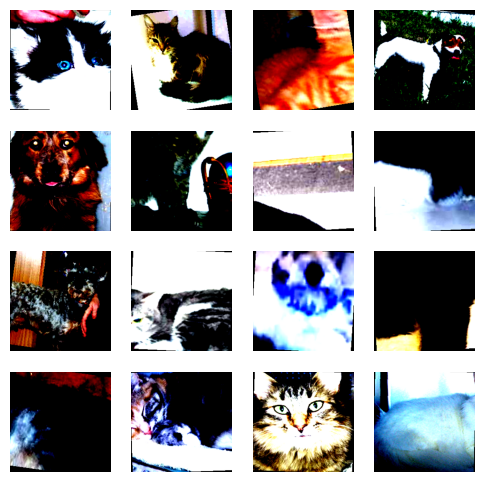

In [8]:
# Function for vusialisation images from batch
def show_images(images, denormalize=False):
    if denormalize:
        # Denormalization 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# First batch from train loader
images, _ = next(iter(train_loader))

print("Images with normalization:")
show_images(images, denormalize=False)

Images without normalization:


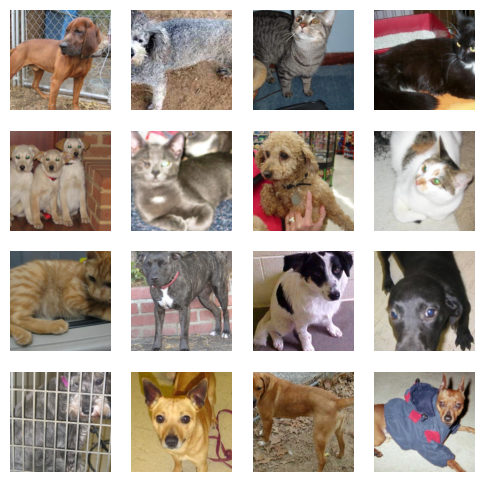

In [9]:
images, _ = next(iter(test_loader))

print("Images without normalization:")
show_images(images, denormalize=True)

# Models

## Baseline simple model cnn

### Create simple model

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 1. Convolutions layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, padding=3, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        # 2. MaxPool for reduce the dimensionality and select importance features
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3. Fully Connected layers 
        self.fc1 = nn.Linear(32 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
         # Create one-dimensional array
        x = x.view(-1, 32 * 28 * 28) 
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [11]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, patience, scheduler):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    
    model.to(device)

    # Train block
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
        train_loss /= total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
    
        # Validation block
        model.eval()
        val_loss, correct, total = 0.0,0,0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
            
                val_loss += loss.item()  * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
    
        val_loss /= total
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Train loss: {train_loss:.4f} Acc: {train_accuracy:.4f} |"
              f"Val loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
        scheduler.step()
        
        # Early stop
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            iter_without_improvements = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else: 
            iter_without_improvements += 1
            if iter_without_improvements > patience:
                model.load_state_dict(best_model_wts)
                break
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Training SimpleCNN

In [13]:
# 1.Initialization model
model = SimpleCNN()

# 2.Loss function 
criterion = nn.CrossEntropyLoss()

# 3.Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# 4.Train params
num_epochs = 70
patience = 5

model_my_CNN, train_losses_my_CNN, train_accuracies_my_CNN, val_losses_my_CNN, val_accuracies_my_CNN = train_model(model, 
                      train_loader, val_loader, 
                      num_epochs, criterion, optimizer, patience, scheduler)

Epoch 1


100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Train loss: 1.0056 Acc: 0.5130 |Val loss: 0.6844 Acc: 0.5835
Epoch 2


100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Train loss: 0.6730 Acc: 0.5941 |Val loss: 0.6512 Acc: 0.6240
Epoch 3


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Train loss: 0.6468 Acc: 0.6262 |Val loss: 0.5950 Acc: 0.6820
Epoch 4


100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Train loss: 0.6285 Acc: 0.6453 |Val loss: 0.5879 Acc: 0.6850
Epoch 5


100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Train loss: 0.6103 Acc: 0.6634 |Val loss: 0.5691 Acc: 0.7080
Epoch 6


100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Train loss: 0.5977 Acc: 0.6749 |Val loss: 0.5530 Acc: 0.7120
Epoch 7


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Train loss: 0.5919 Acc: 0.6817 |Val loss: 0.5462 Acc: 0.7150
Epoch 8


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Train loss: 0.5850 Acc: 0.6878 |Val loss: 0.5158 Acc: 0.7445
Epoch 9


100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Train loss: 0.5743 Acc: 0.6973 |Val loss: 0.5136 Acc: 0.7535
Epoch 10


100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Train loss: 0.5668 Acc: 0.7000 |Val loss: 0.5191 Acc: 0.7415
Epoch 11


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Train loss: 0.5561 Acc: 0.7072 |Val loss: 0.4781 Acc: 0.7680
Epoch 12


100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Train loss: 0.5525 Acc: 0.7131 |Val loss: 0.4798 Acc: 0.7680
Epoch 13


100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Train loss: 0.5480 Acc: 0.7167 |Val loss: 0.4625 Acc: 0.7855
Epoch 14


100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Train loss: 0.5377 Acc: 0.7269 |Val loss: 0.4635 Acc: 0.7785
Epoch 15


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


Train loss: 0.5346 Acc: 0.7264 |Val loss: 0.4533 Acc: 0.7850
Epoch 16


100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Train loss: 0.5254 Acc: 0.7321 |Val loss: 0.4420 Acc: 0.7945
Epoch 17


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Train loss: 0.5223 Acc: 0.7348 |Val loss: 0.4453 Acc: 0.7860
Epoch 18


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Train loss: 0.5182 Acc: 0.7407 |Val loss: 0.4427 Acc: 0.7935
Epoch 19


100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Train loss: 0.5150 Acc: 0.7394 |Val loss: 0.4409 Acc: 0.7945
Epoch 20


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Train loss: 0.5101 Acc: 0.7475 |Val loss: 0.4375 Acc: 0.7930
Epoch 21


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Train loss: 0.5137 Acc: 0.7411 |Val loss: 0.4375 Acc: 0.7950
Epoch 22


100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Train loss: 0.5155 Acc: 0.7452 |Val loss: 0.4368 Acc: 0.7985
Epoch 23


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


Train loss: 0.5100 Acc: 0.7449 |Val loss: 0.4344 Acc: 0.7990
Epoch 24


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Train loss: 0.5127 Acc: 0.7435 |Val loss: 0.4370 Acc: 0.7985
Epoch 25


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Train loss: 0.5171 Acc: 0.7417 |Val loss: 0.4420 Acc: 0.7925
Epoch 26


100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Train loss: 0.5199 Acc: 0.7360 |Val loss: 0.4391 Acc: 0.7935
Epoch 27


100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Train loss: 0.5214 Acc: 0.7359 |Val loss: 0.4357 Acc: 0.7980
Epoch 28


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Train loss: 0.5201 Acc: 0.7379 |Val loss: 0.4321 Acc: 0.8010
Epoch 29


100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Train loss: 0.5174 Acc: 0.7416 |Val loss: 0.4383 Acc: 0.8025
Epoch 30


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Train loss: 0.5178 Acc: 0.7406 |Val loss: 0.4393 Acc: 0.8000
Epoch 31


100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Train loss: 0.5219 Acc: 0.7383 |Val loss: 0.4361 Acc: 0.8050
Epoch 32


100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Train loss: 0.5194 Acc: 0.7416 |Val loss: 0.4560 Acc: 0.7960
Epoch 33


100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Train loss: 0.5219 Acc: 0.7420 |Val loss: 0.4522 Acc: 0.7980
Epoch 34


100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Train loss: 0.5148 Acc: 0.7443 |Val loss: 0.4303 Acc: 0.8100
Epoch 35


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Train loss: 0.5140 Acc: 0.7405 |Val loss: 0.4813 Acc: 0.7675
Epoch 36


100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


Train loss: 0.5165 Acc: 0.7416 |Val loss: 0.4277 Acc: 0.8080
Epoch 37


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


Train loss: 0.5110 Acc: 0.7483 |Val loss: 0.4161 Acc: 0.8120
Epoch 38


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Train loss: 0.5121 Acc: 0.7427 |Val loss: 0.4258 Acc: 0.7990
Epoch 39


100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Train loss: 0.5065 Acc: 0.7487 |Val loss: 0.4587 Acc: 0.7760
Epoch 40


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Train loss: 0.5039 Acc: 0.7501 |Val loss: 0.4334 Acc: 0.8030
Epoch 41


100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Train loss: 0.4999 Acc: 0.7501 |Val loss: 0.4540 Acc: 0.7930
Epoch 42


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Train loss: 0.5000 Acc: 0.7552 |Val loss: 0.4365 Acc: 0.7885
Epoch 43


100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Train loss: 0.4925 Acc: 0.7576 |Val loss: 0.4061 Acc: 0.8125
Epoch 44


100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Train loss: 0.4913 Acc: 0.7596 |Val loss: 0.4152 Acc: 0.8105
Epoch 45


100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Train loss: 0.4931 Acc: 0.7588 |Val loss: 0.3913 Acc: 0.8380
Epoch 46


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


Train loss: 0.4880 Acc: 0.7574 |Val loss: 0.3919 Acc: 0.8285
Epoch 47


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Train loss: 0.4808 Acc: 0.7660 |Val loss: 0.4227 Acc: 0.8080
Epoch 48


100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Train loss: 0.4769 Acc: 0.7685 |Val loss: 0.3980 Acc: 0.8150
Epoch 49


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Train loss: 0.4729 Acc: 0.7692 |Val loss: 0.4028 Acc: 0.8195
Epoch 50


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Train loss: 0.4744 Acc: 0.7708 |Val loss: 0.3725 Acc: 0.8330
Epoch 51


100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Train loss: 0.4689 Acc: 0.7708 |Val loss: 0.3707 Acc: 0.8400
Epoch 52


100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Train loss: 0.4545 Acc: 0.7814 |Val loss: 0.3637 Acc: 0.8360
Epoch 53


100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Train loss: 0.4570 Acc: 0.7821 |Val loss: 0.3570 Acc: 0.8470
Epoch 54


100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Train loss: 0.4516 Acc: 0.7824 |Val loss: 0.3618 Acc: 0.8460
Epoch 55


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Train loss: 0.4585 Acc: 0.7796 |Val loss: 0.3696 Acc: 0.8410
Epoch 56


100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Train loss: 0.4500 Acc: 0.7852 |Val loss: 0.3430 Acc: 0.8540
Epoch 57


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Train loss: 0.4486 Acc: 0.7832 |Val loss: 0.3426 Acc: 0.8555
Epoch 58


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Train loss: 0.4368 Acc: 0.7955 |Val loss: 0.3370 Acc: 0.8565
Epoch 59


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


Train loss: 0.4358 Acc: 0.7941 |Val loss: 0.3364 Acc: 0.8595
Epoch 60


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Train loss: 0.4405 Acc: 0.7911 |Val loss: 0.3385 Acc: 0.8535
Epoch 61


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


Train loss: 0.4369 Acc: 0.7925 |Val loss: 0.3386 Acc: 0.8515
Epoch 62


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Train loss: 0.4350 Acc: 0.7927 |Val loss: 0.3369 Acc: 0.8570
Epoch 63


100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


Train loss: 0.4334 Acc: 0.7955 |Val loss: 0.3349 Acc: 0.8555
Epoch 64


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Train loss: 0.4372 Acc: 0.7950 |Val loss: 0.3377 Acc: 0.8565
Epoch 65


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]

Train loss: 0.4339 Acc: 0.7981 |Val loss: 0.3328 Acc: 0.8535


### Result

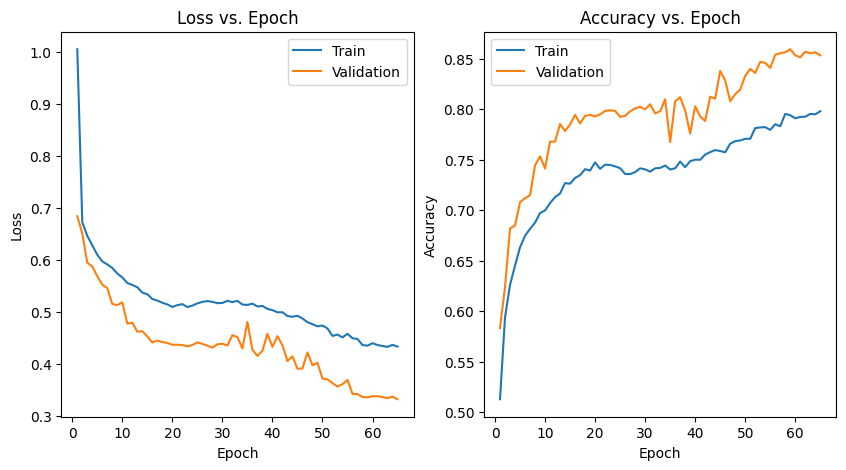

In [14]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_my_CNN)+1), train_losses_my_CNN, label='Train')
plt.plot(range(1, len(val_losses_my_CNN)+1), val_losses_my_CNN, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_my_CNN)+1), train_accuracies_my_CNN, label='Train')
plt.plot(range(1, len(val_accuracies_my_CNN)+1), val_accuracies_my_CNN, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [15]:
# Model prediction result
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Calcs f1 weighted score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Visualisation confusion matrix
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2500
           1       0.83      0.86      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

Test Accuracy: 0.8424


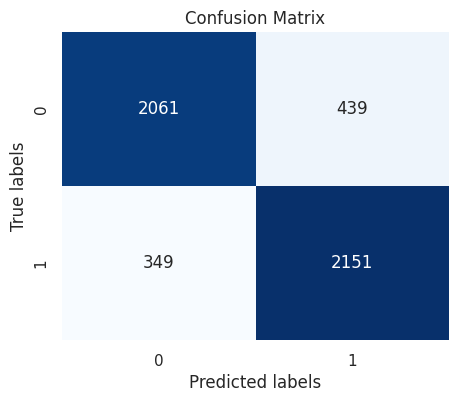

In [18]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_my_CNN, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(2)))

In [ ]:
#model = SimpleCNN()
#model = torch.load('/kaggle/input/model/pytorch/default/1/full_model.pth')
#model.eval()

### How works model

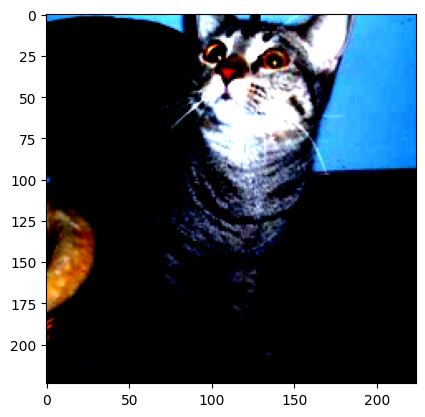

In [41]:
data_iter = iter(test_loader)
image, label = next(data_iter)
image_np = image[2].squeeze().numpy()
image_np = np.moveaxis(image_np, 0, -1)
plt.imshow(image_np)
plt.show()

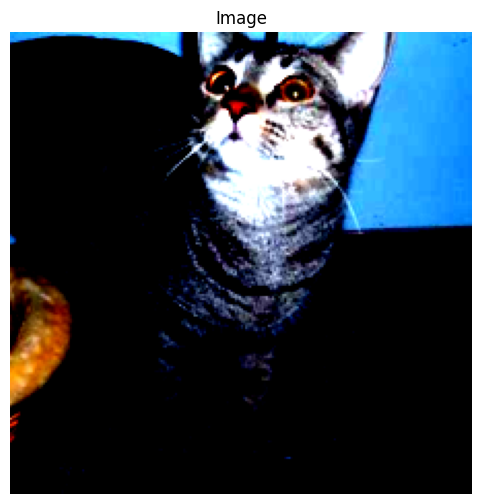

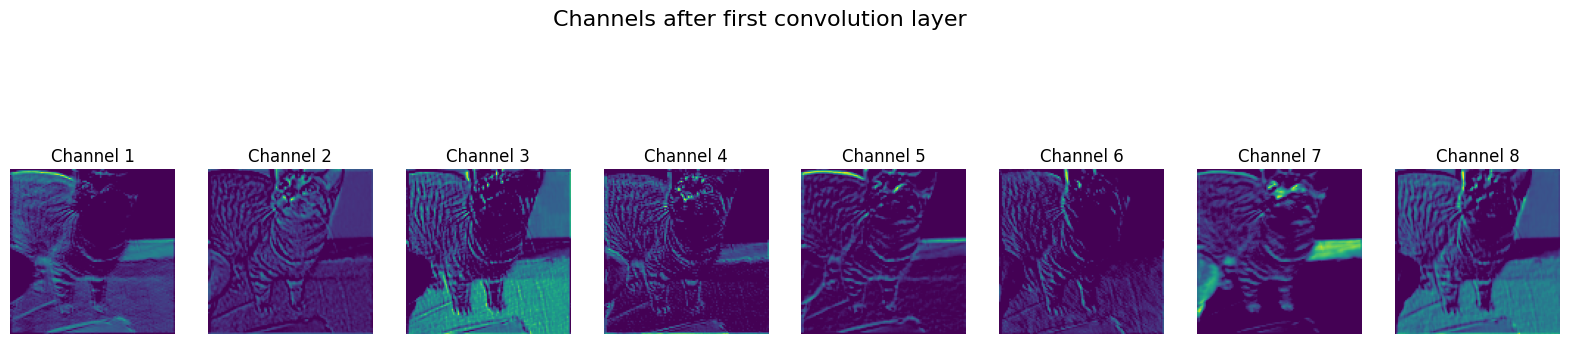

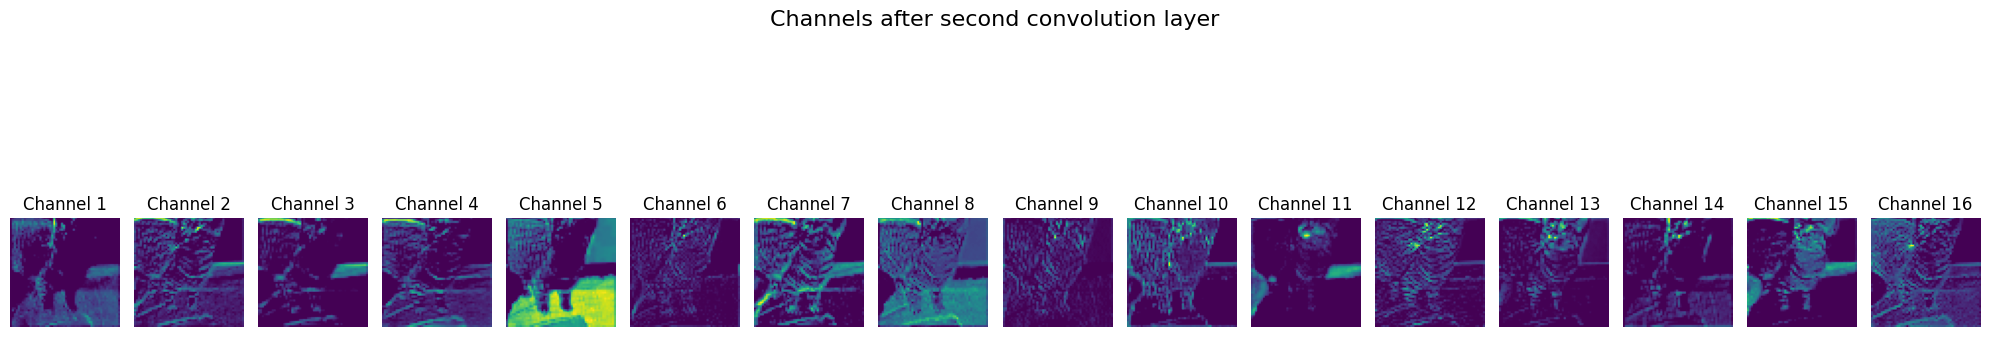

In [42]:
inputs, labels = image.cuda(), label.cuda()
test_image = inputs[2].unsqueeze(0)

model_my_CNN.eval()

with torch.no_grad():
    x_1 = model_my_CNN.conv1(test_image)
    x_1 = model_my_CNN.bn1(x_1)
    feature_maps_1 = F.relu(x_1)
    
feature_maps_1 = feature_maps_1.squeeze(0).cpu().numpy()

with torch.no_grad():
    x_2 = model_my_CNN.conv1(test_image)
    x_2 = model_my_CNN.bn1(x_2)
    x_2 = F.relu(x_2)
    x_2 = model_my_CNN.conv2(x_2)
    x_2 = model_my_CNN.bn2(x_2)
    x_2 = F.relu(x_2)
    x_2 = model_my_CNN.pool(x_2)
    feature_maps_2 = x_2 

feature_maps_2 = feature_maps_2.squeeze(0).cpu().numpy()

# Visualisation image
plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')
plt.show()

# Visualisation channels
num_feature_maps_1 = feature_maps_1.shape[0]
fig, axs = plt.subplots(1, num_feature_maps_1, figsize=(20, 5))
fig.suptitle('Channels after first convolution layer', fontsize=16)

for i in range(num_feature_maps_1):
    ax = axs[i]
    ax.imshow(feature_maps_1[i], cmap='viridis')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

num_feature_maps_2 = feature_maps_2.shape[0]
fig, axs = plt.subplots(1, num_feature_maps_2, figsize=(20, 5))
fig.suptitle('Channels after second convolution layer', fontsize=16)

for i in range(num_feature_maps_2):
    ax = axs[i]
    ax.imshow(feature_maps_2[i], cmap='viridis')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## ResNet 18

### Learn only fc

**Train only the fully connected layer first. The convolutional layers of ResNet act as feature extractors.**

In [43]:
num_classes = 2

In [45]:
model_resNet18_fc = models.resnet18(pretrained=True)

for param in model_resNet18_fc.parameters():
    param.requires_grad = False
    
model_resNet18_fc.fc = nn.Linear(model_resNet18_fc.fc.in_features, num_classes)

In [46]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_resNet18_fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 70
patience = 5

model_ResNet18_fc, train_losses_ResNet18_fc, train_accuracies_ResNet18_fc, val_losses_ResNet18_fc, val_accuracies_ResNet18_fc = train_model(model_resNet18_fc, 
                             train_loader, 
                             val_loader, 
                             num_epochs, 
                             criterion, 
                             optimizer, 
                             patience, 
                             scheduler)

Epoch 1


100%|██████████| 32/32 [00:05<00:00,  6.26it/s]


Train loss: 0.2275 Acc: 0.9023 |Val loss: 0.0669 Acc: 0.9805
Epoch 2


100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Train loss: 0.1661 Acc: 0.9268 |Val loss: 0.0549 Acc: 0.9825
Epoch 3


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Train loss: 0.1638 Acc: 0.9297 |Val loss: 0.0519 Acc: 0.9815
Epoch 4


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Train loss: 0.1516 Acc: 0.9342 |Val loss: 0.0556 Acc: 0.9790
Epoch 5


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Train loss: 0.1538 Acc: 0.9341 |Val loss: 0.0581 Acc: 0.9775
Epoch 6


100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Train loss: 0.1546 Acc: 0.9317 |Val loss: 0.0488 Acc: 0.9820
Epoch 7


100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Train loss: 0.1545 Acc: 0.9328 |Val loss: 0.0486 Acc: 0.9820
Epoch 8


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


Train loss: 0.1521 Acc: 0.9325 |Val loss: 0.0474 Acc: 0.9830
Epoch 9


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Train loss: 0.1474 Acc: 0.9372 |Val loss: 0.0487 Acc: 0.9825
Epoch 10


100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Train loss: 0.1485 Acc: 0.9321 |Val loss: 0.0477 Acc: 0.9845
Epoch 11


100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Train loss: 0.1441 Acc: 0.9371 |Val loss: 0.0495 Acc: 0.9820
Epoch 12


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Train loss: 0.1439 Acc: 0.9372 |Val loss: 0.0462 Acc: 0.9840
Epoch 13


100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Train loss: 0.1405 Acc: 0.9388 |Val loss: 0.0457 Acc: 0.9840
Epoch 14


100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Train loss: 0.1408 Acc: 0.9382 |Val loss: 0.0465 Acc: 0.9835
Epoch 15


100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Train loss: 0.1424 Acc: 0.9382 |Val loss: 0.0453 Acc: 0.9840
Epoch 16


100%|██████████| 32/32 [00:04<00:00,  6.56it/s]

Train loss: 0.1421 Acc: 0.9359 |Val loss: 0.0488 Acc: 0.9815


#### Result

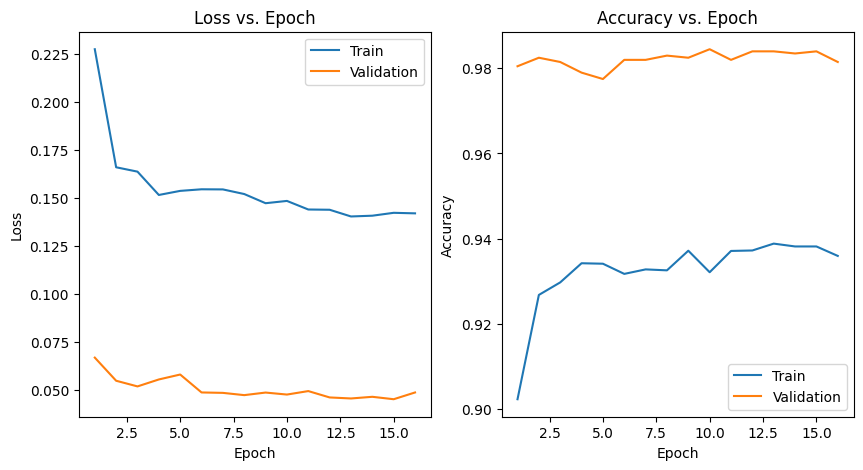

In [47]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_ResNet18_fc)+1), train_losses_ResNet18_fc, label='Train')
plt.plot(range(1, len(val_losses_ResNet18_fc)+1), val_losses_ResNet18_fc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_ResNet18_fc)+1), train_accuracies_ResNet18_fc, label='Train')
plt.plot(range(1, len(val_accuracies_ResNet18_fc)+1), val_accuracies_ResNet18_fc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2500
           1       0.97      0.99      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Test Accuracy: 0.9774


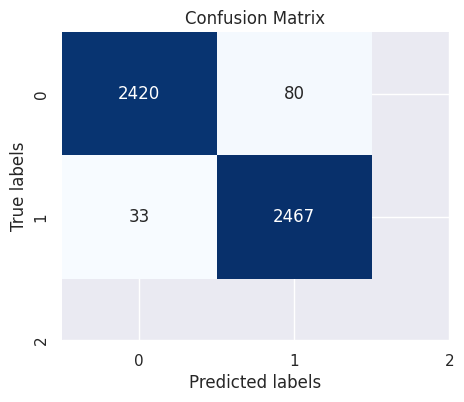

In [48]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_ResNet18_fc, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

### Gradually train the model's deeper layers.

#### New training function with Gradually

In [56]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, patience=5, scheduler=None, unfreeze_fn=None, device="cuda"):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_val_accuracy = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    iter_without_improvements = 0

    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # If have unfreeze
        if unfreeze_fn is not None:
            unfreeze_fn(model, epoch)

        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc="Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
        train_loss /= total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Val"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
            
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
    
        val_loss /= total
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Train loss: {train_loss:.4f}, acc: {train_accuracy:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_accuracy:.4f}")
        
        if scheduler is not None:
            scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            iter_without_improvements = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else: 
            iter_without_improvements += 1
            if iter_without_improvements > patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [57]:
def gradual_unfreeze(model, epoch):
    if epoch == 5:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch == 10:
        for param in model.layer3.parameters():
            param.requires_grad = True

In [58]:
model_Resnet18_grad = models.resnet18(pretrained=True)
model_Resnet18_grad.fc = nn.Linear(model_Resnet18_grad.fc.in_features, num_classes)
model_Resnet18_grad = model_Resnet18_grad.to(device)

In [60]:
for param in model_Resnet18_grad.parameters():
    param.requires_grad = False
for param in model_Resnet18_grad.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_Resnet18_grad.parameters()), lr=1e-3)
model_Resnet18_grad, train_losses_ResNet18_grad, train_accuracies_ResNet18_grad, val_losses_ResNet18_grad, val_accuracies_ResNet18_grad = train_model(model_Resnet18_grad, train_loader, val_loader, 50, criterion, optimizer, patience=5, unfreeze_fn=gradual_unfreeze)


Epoch 1/50


Val: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


Train loss: 0.2216, acc: 0.9063 | Val loss: 0.0624, acc: 0.9815

Epoch 2/50


Val: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Train loss: 0.1646, acc: 0.9283 | Val loss: 0.0544, acc: 0.9810

Epoch 3/50


Val: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Train loss: 0.1496, acc: 0.9344 | Val loss: 0.0462, acc: 0.9830

Epoch 7/50


Val: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Train loss: 0.1537, acc: 0.9323 | Val loss: 0.0487, acc: 0.9820

Epoch 8/50


Val: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Train loss: 0.1432, acc: 0.9382 | Val loss: 0.0448, acc: 0.9830

Epoch 9/50


Val: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]

Train loss: 0.1531, acc: 0.9344 | Val loss: 0.0442, acc: 0.9840
Early stopping


#### Result

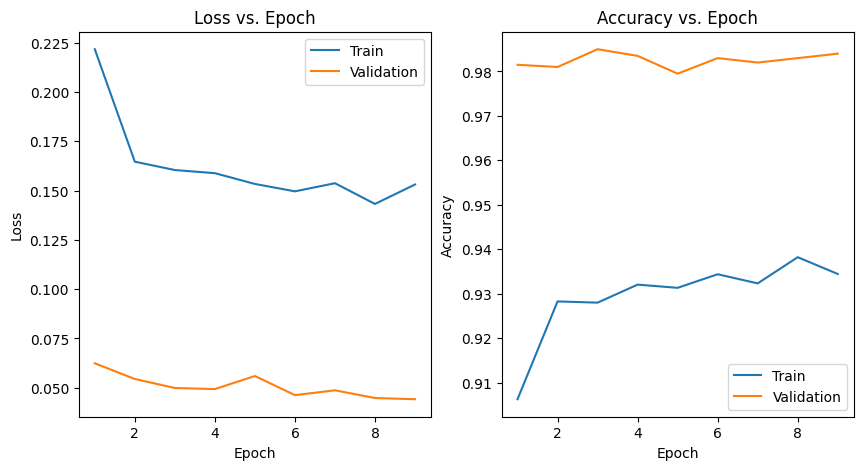

In [63]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_ResNet18_grad)+1), train_losses_ResNet18_grad, label='Train')
plt.plot(range(1, len(val_losses_ResNet18_grad)+1), val_losses_ResNet18_grad, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_ResNet18_grad)+1), train_accuracies_ResNet18_grad, label='Train')
plt.plot(range(1, len(val_accuracies_ResNet18_grad)+1), val_accuracies_ResNet18_grad, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2500
           1       0.97      0.98      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Test Accuracy: 0.9776


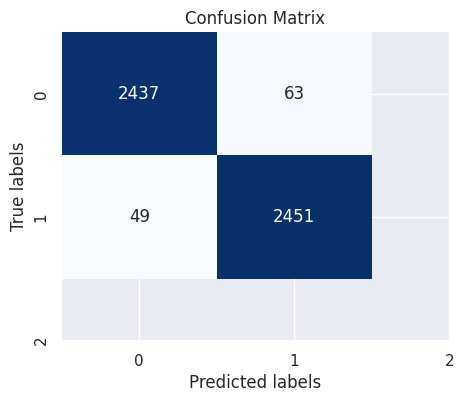

In [64]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_Resnet18_grad, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

## Where is models looking

In [76]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        loss.backward()

        grads = self.gradients[0].cpu().numpy()  # (C, H, W)
        act = self.activations[0].cpu().numpy()  # (C, H, W)

        weights = grads.mean(axis=(1, 2))
        cam = np.zeros(act.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * act[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.size(2), input_tensor.size(3)))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [77]:
def get_misclassified(model, dataloader, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
    return misclassified

In [84]:
def compare_gradcam(model1, target_layer1, model2, target_layer2, dataloader, device, n=5):
    gradcam1 = GradCAM(model1, target_layer1)
    gradcam2 = GradCAM(model2, target_layer2)

    errors = get_misclassified(model1, dataloader, device)
    print(f"misstake baseline CNN: {len(errors)}")

    for i in range(min(n, len(errors))):
        img, true_label, pred_label = errors[i]
        input_tensor = img.unsqueeze(0).to(device)

        cam1 = gradcam1.generate(input_tensor)
        cam2 = gradcam2.generate(input_tensor)

        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        def overlay(img_np, cam):
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            return 0.4 * heatmap + 0.6 * (img_np * 255)

        overlay1 = overlay(img_np, cam1)
        overlay2 = overlay(img_np, cam2)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(overlay1.astype(np.uint8))
        plt.title("Model 1")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay2.astype(np.uint8))
        plt.title("Model 2")
        plt.axis("off")

        plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


misstake baseline CNN: 788


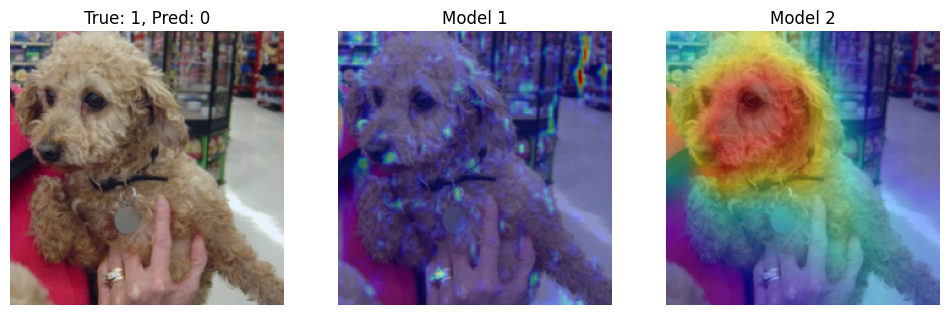

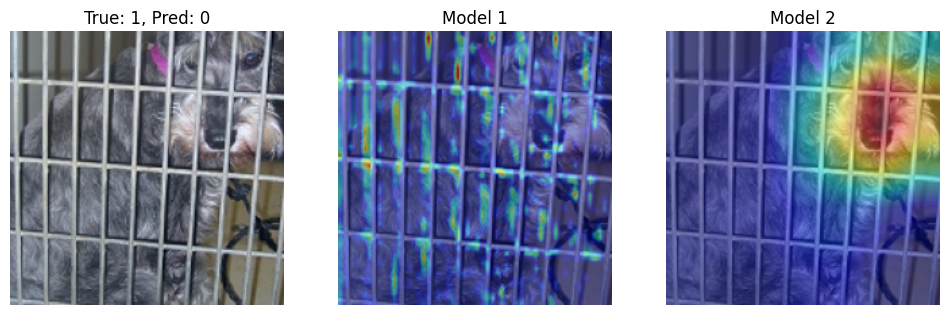

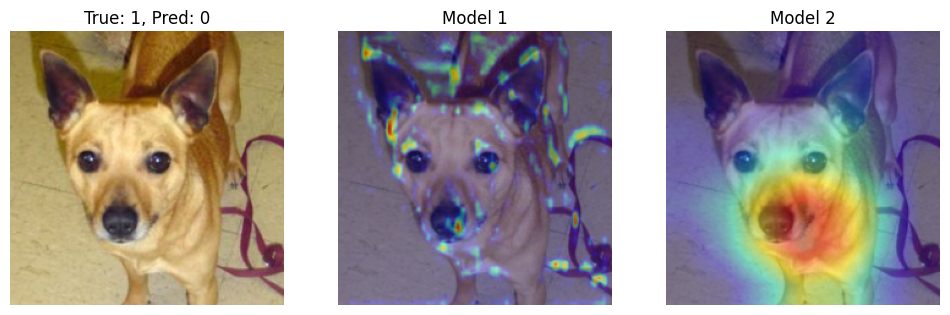

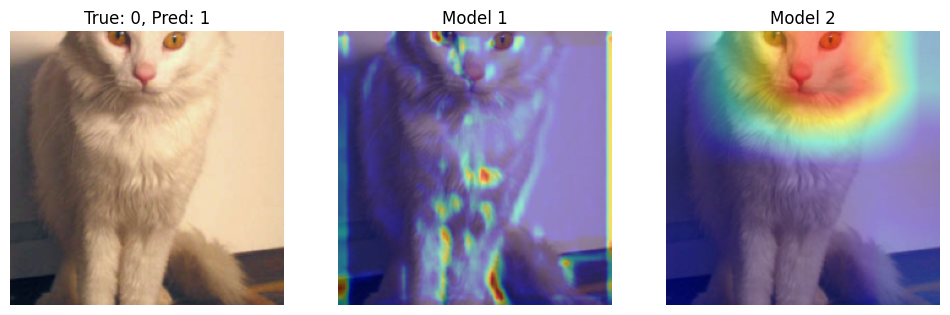

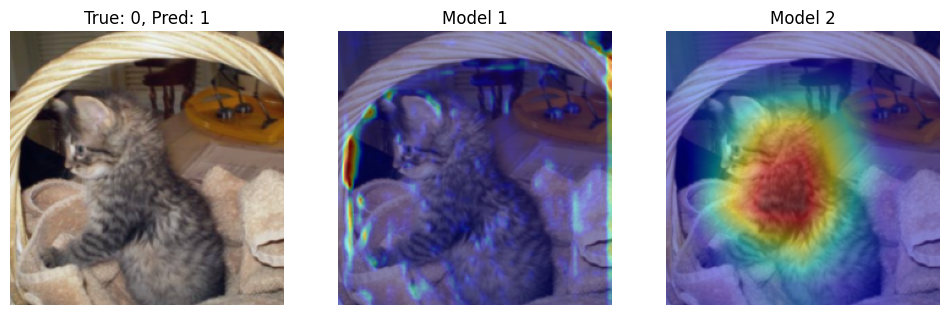

In [86]:
target_layer_baseline = model_my_CNN.conv3

target_layer_resnet = model_Resnet18_grad.layer4[-1]

compare_gradcam(model_my_CNN, target_layer_baseline,
                model_Resnet18_grad, target_layer_resnet,
                test_loader, device, n=5)

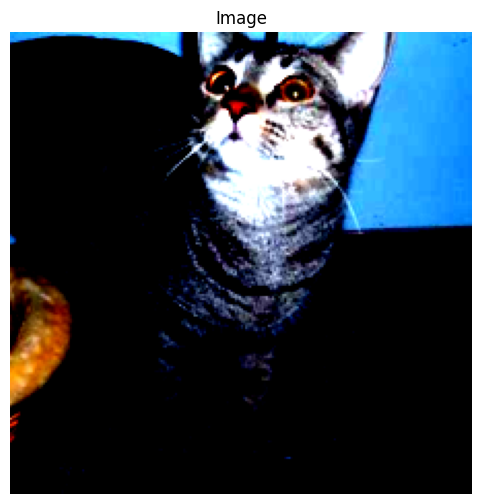

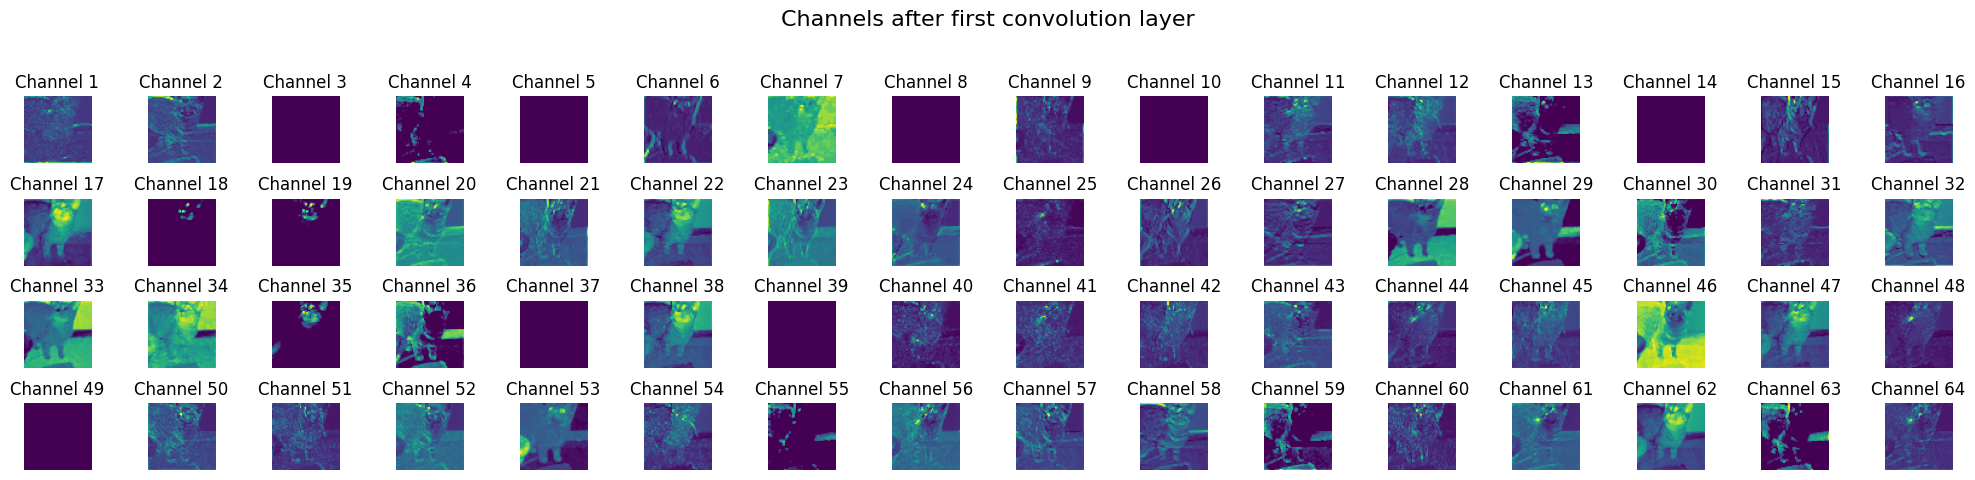

In [95]:
inputs, labels = image.cuda(), label.cuda()
test_image = inputs[2].unsqueeze(0)

model_Resnet18_grad.eval()

with torch.no_grad():
    x_1 = model_Resnet18_grad.conv1(test_image)
    x_1 = model_Resnet18_grad.bn1(x_1)
    x_1 = F.relu(x_1)
    feature_maps_1 = model_Resnet18_grad.maxpool(x_1)
    
feature_maps_1 = feature_maps_1.squeeze(0).cpu().numpy()


# Visualisation image
plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')
plt.show()

rows = 4
cols = int(num_feature_maps_1/ rows)

# Visualisation channels
num_feature_maps_1 = feature_maps_1.shape[0]
fig, axs = plt.subplots(rows, cols, figsize=(20, 5))
fig.suptitle('Channels after first convolution layer', fontsize=16)

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        ax = axs[i, j]
        ax.imshow(feature_maps_1[index], cmap='viridis')
        ax.set_title(f'Channel {index + 1}')
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 